In [44]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import sklearn as sk

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

import mlflow

#----------------------------
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, precision_recall_fscore_support, 
                             precision_score, recall_score, roc_auc_score)

In [45]:
# Set graphs style

sns.set_style('whitegrid')
#plt.style.use("fivethirtyeight")
plt.style.use('seaborn-v0_8')
%matplotlib inline

In [46]:
# Loading the data

AAPLData = pd.read_hdf('../data/lSTMData/lSTMData.h5','AAPL')
AAPLData.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-09-04,23.777143,24.112143,23.732143,24.106071,20.444380,367892000
2012-09-05,24.127501,24.155357,23.914286,23.936787,20.300814,336375200
2012-09-06,24.041786,24.224644,23.957144,24.152500,20.483757,391196400
2012-09-07,24.216070,24.374287,24.134644,24.301430,20.610065,329666400
2012-09-10,24.301786,24.403214,23.646429,23.669287,20.073950,487998000


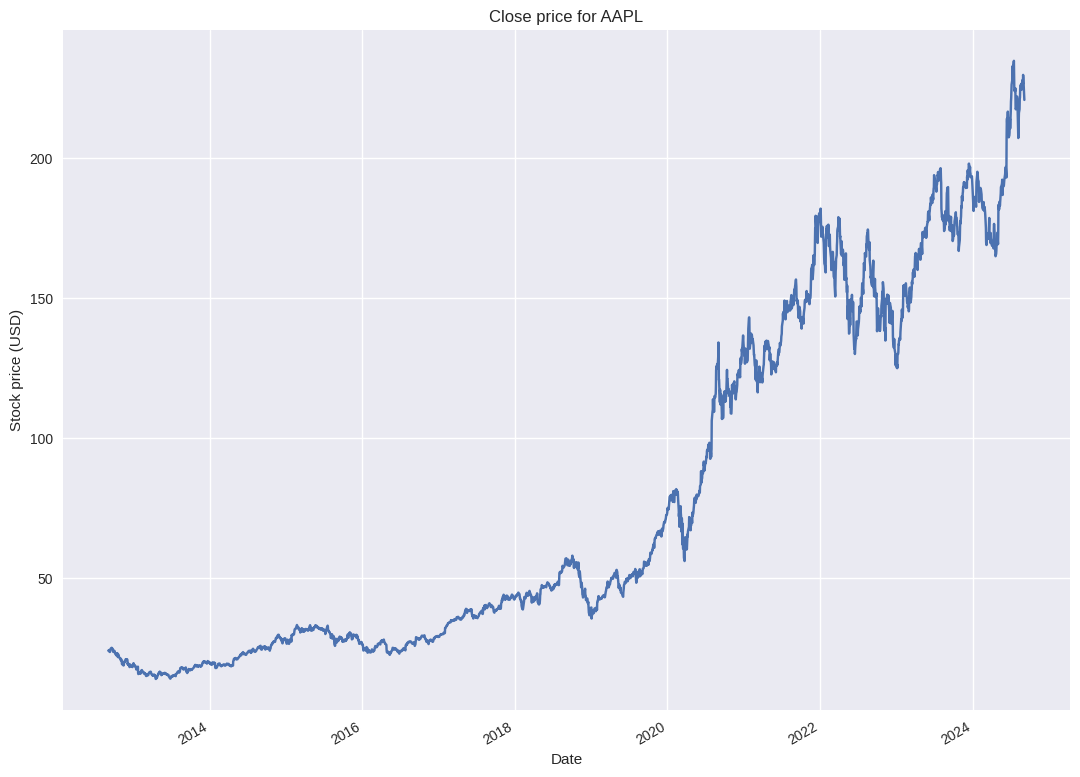

In [47]:
# Visualize the data

fig = plt.figure(figsize=(13,10))

AAPLData['Close'].plot()
plt.ylabel('Stock price (USD)')
plt.title('Close price for AAPL')
plt.show()

In [61]:
print(f"Tracking Server URI: '{mlflow.get_tracking_uri()}'")

Tracking Server URI: 'file:///home/sebastian/Desktop/For_studyng/Projects/StockMarket/model_generate/mlruns'


In [60]:
mlflow.end_run()

In [68]:

# Sequences for the LSTM
def sequences(data:np.ndarray, timeStep:int):
    x = []
    y = []
    
    for i in range(len(data) - timeStep - 1):
        x.append(data[i:(i + timeStep)])
        y.append(data[i + timeStep])
    return np.array(x), np.array(y), i + 1
    
# Metric for the error    
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

# Function to run mlflow experiment
def run_experiment(data, trainDataPercentage:float, timeStep:int, epochs:int, batch_size:int,lr:float, run_name:str):
    
    # Scale data
    scaler = MinMaxScaler(feature_range=(0,1))
    data = data[['Close']].values
    
    scaled_data = scaler.fit_transform(data)
    
    
    # take training data
    
    trainDataLen = int(len(data) * trainDataPercentage)
    trainData = scaled_data[:trainDataLen, 0]
    
    x_train, y_train, timeSteps = sequences(data=trainData,timeStep=timeStep)
    
    # Reshape data to train (samples, timeSteps, features)
    #x_train = x_train.reshape(trainDataLen, timeSteps, 1)
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
    
    # Create model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(timeSteps,1)))
    model.add(LSTM(50, return_sequences=False))
    
    model.add(Dense(20))
    model.add(Dense(1))
    
    # Define hyperparams
    lr = lr
    optimizer = Adam(learning_rate=lr)
    epochs = epochs
    batch_size = batch_size
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # train model
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
    
    # Test model
    # Create training dataset
    testData = scaled_data[trainDataLen:,0]
    
    # Create testing sequences
    y_test = data[-timeStep]
    x_test,_,_ = sequences(data=testData,timeStep=timeStep)
    
    #                      (samples, timeSteps, features)
    #x_test = x_test.reshape(trainDataLen, timeSteps, 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    
    # Make predictions
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    
    # Get RMSE
    rmseValue = rmse(y_true=y_test, y_pred=predictions)
    
    
    with mlflow.start_run(run_name= run_name): 
        mlflow.log_param('Train percentage', trainDataPercentage)
        mlflow.log_param('epohcs', epochs)
        mlflow.log_param('batch_size', batch_size)
        mlflow.log_param('Learning rate', lr)
        mlflow.log_metric('rmse', rmseValue)
        
        mlflow.sklearn.log_model(model, artifact_path='model')
    
    return rmseValue
    

In [69]:
# Run the experiment!

context = {
    'data': AAPLData,
    'trainDataPercentage':0.9,
    'timeStep':40, 
    'epochs':1,
    'batch_size':1,
    'lr':0.01,
    'run_name': 'LSTMStock2'
}
mlflow.set_tracking_uri("file:/home/sebastian/Desktop/For_studyng/Projects/StockMarket/mlruns")

mlflow.set_experiment("LSTM_experiment")   
rmseValue = run_experiment(**context)
rmseValue


/home/sebastian/.cache/pypoetry/virtualenvs/stockmarket-dPE3Oc---py3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2676/2676 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0180
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


2024/09/07 23:02:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


51.248476869115464

In [64]:
experiment = mlflow.get_experiment_by_name("LSTM_experiment")
print(experiment)

<Experiment: artifact_location='file:///home/sebastian/Desktop/For_studyng/Projects/StockMarket/model_generate/mlruns/520870674275146895', creation_time=1725766138999, experiment_id='520870674275146895', last_update_time=1725766138999, lifecycle_stage='active', name='LSTM_experiment', tags={}>


In [36]:
# PLot results



[1, 4, 7]
[2, 4, 8, 9, 3, 65, 9, 0, 3, 4, 6, 8, 2, 5, 9, 8, 2]


In [ ]:
#mlflow ui --backend-store-uri /home/sebastian/Desktop/For_studyng/Projects/StockMarket/mlruns